# Calibration of transmission risk parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from os.path import join
from itertools import product

from model_nursing_home import SEIRX_nursing_home
from analysis_functions import *
import importlib
import viz
# for progress bars
from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

### Calibration of basic reproduction number (no interventions)

In [3]:
res_path = '../../../results/nursing_homes'

In [6]:
sim_name = 'basic_reproduction_calibration'
N_steps = 300
verbosity = 0
runs = 1000
testing = False
index_case_group = 'employee'
G = nx.readwrite.gpickle.read_gpickle('../data/interactions_single_quarter.gpickle')
agent_types = \
    {
    'employee':{'screening_interval': None,
                'index_probability': 0,
                'transmission_risk': 0.0275,
                'reception_risk': 1,
                'symptom_probability': 0.6},
    
    'resident':{'screening_interval': None,
                'index_probability': 0,
                'transmission_risk': 0.0275,
                'reception_risk': 1,
                'symptom_probability': 0.6}
    }


# progress bar
f = IntProgress(min=0, max=runs)
display(f)

results = pd.DataFrame()
for r in range(runs):
    f.value = r
    
    # instantiate model (testing turned off for calibration and related 
    # parameters not needed)
    model = SEIRX_nursing_home(G, verbosity, testing=testing,
              diagnostic_test_type = 'one_day_PCR',
              preventive_screening_test_type = 'same_day_LAMP',
              index_case = index_case_group,
              follow_up_testing_interval = None,
              agent_types = agent_types)
    
    for i in range(N_steps):
        model.step()
        
        # break if first outbreak is over
        if len([a for a in model.schedule.agents if \
            (a.exposed == True or a.infectious == True)]) == 0:
            break
        
    R0, _ = calculate_finite_size_R0(model)
    infected_employees, infected_patients = count_infected(model)
    transmissions = sum([a.transmissions for a in model.schedule.agents])
    data = model.datacollector.get_model_vars_dataframe()
    
    results = results.append({'run':r, 
                              'R0':R0,
                              'infected_employees':infected_employees,
                              'infected_patients':infected_patients,
                              'transmissions':transmissions,
                              'duration':len(data)},
                            ignore_index=True)
    
results.to_csv(join(res_path, 'simulation_results/{}_index_case_{}.csv'\
                    .format(sim_name, index_case_group)),
               index=False)

IntProgress(value=0, max=1000)

In [7]:
print('R0 = {:1.3f} +- {:1.3f}'\
      .format(results['R0'].mean(), results['R0'].std()))

R0 = 2.606 +- 1.329


**v1.1**  
Statistics for 1000 runs (18 employees, 34 residents). The following transmission settings lead to a reproduction number of $R_0 = 4.822\pm 2.008$ (resident as index case) and $R_0 = 2.606 \pm 1.329$ (employee as index case):
* transmission risk employee = 0.022
* transmission risk resident = 0.022
* reception risk employee = 1.0
* reception risk resident = 1.0
* transmission area multiplier for patients: close = 2, intermediate = 1, far = 0.25
* symptom probability = 0.6, subclinical multiplier = 1

**v1.0**  
Statistics for 1000 runs (18 employees, 34 residents). The following transmission settings lead to a reproduction number of $R_0 = 3.784\pm 1.828$ (resident as index case) and $R_0 = 2.962 \pm 1.525$ (employee as index case):
* transmission risk resident $\rightarrow$ resident = 0.01
* transmission risk resident $\rightarrow$ employee = 0.01
* transmission risk employee $\rightarrow$ resident = 0.01
* transmission risk employee $\rightarrow$ employee = 0.01
* transmission area multiplier for patients: room = 4, table = 2, quarters = 1
* symptom probability = 0.6, subclinical multiplier = 1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


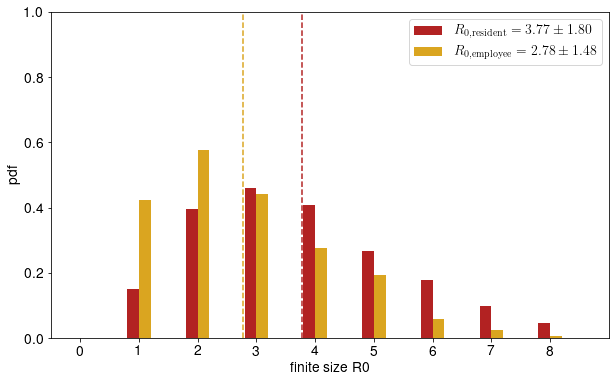

In [22]:
results_resident = pd.read_csv(join(res_path, 'simulation_results/basic_reproduction_calibration_index_case_resident.csv'))
results_employee = pd.read_csv(join(res_path, 'simulation_results/basic_reproduction_calibration_index_case_employee.csv'))

sim_name = 'basic_reproduction_calibration_R0'
fig, ax = plt.subplots(figsize=(10,6))
R0_employee = results_employee['R0'].mean()
R0_employee_std = results_employee['R0'].std()
R0_resident = results_resident['R0'].mean()
R0_resident_std = results_resident['R0'].std()

xmax = 9
ymax = 1

ax.hist([results_resident['R0'], results_employee['R0']], \
         label=['$R_{{0, \\mathrm{{resident}}}}={:1.2f}\\pm{:1.2f}$'\
                    .format(R0_resident, R0_resident_std),\
                 '$R_{{0, \\mathrm{{employee}}}}={:1.2f}\\pm{:1.2f}$'\
                    .format(R0_employee, R0_employee_std)],
          bins=np.arange(0, xmax, 0.5), density=True,
          color=['FireBrick', 'GoldenRod'], align='left')

ax.plot([R0_resident, R0_resident], [0, ymax], '--', color='FireBrick')
ax.plot([R0_employee, R0_employee], [0, ymax], '--', color='GoldenRod')

ax.legend(fontsize=14)
ax.set_xticks(range(0, xmax))
ax.set_xticklabels(range(0, xmax), fontsize=14)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
ax.set_xlabel('finite size R0', fontsize=14)
ax.set_ylabel('pdf', fontsize=14)
ax.set_ylim(0, ymax)
ax.set_xlim(-0.5, xmax)

plt.savefig(join(res_path, 'plots/{}.pdf'.format(sim_name)),
                 transparent=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


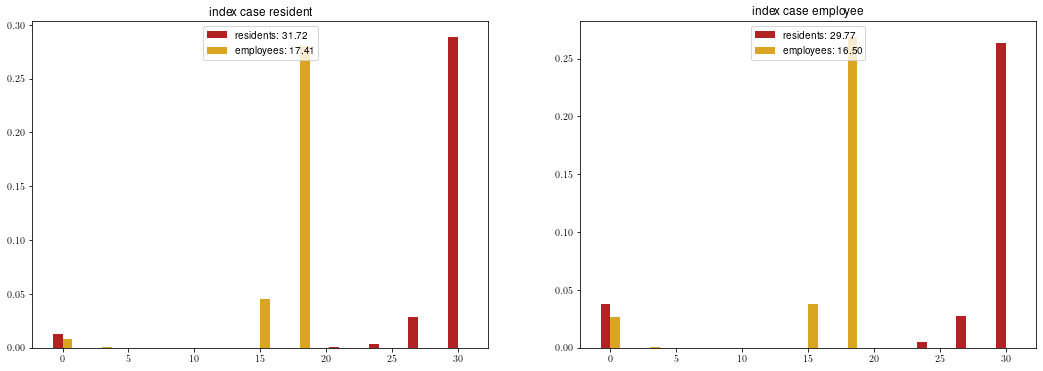

In [23]:
sim_name = 'basic_reproduction_calibration_Ninfected'
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

results_resident = pd.read_csv(join(res_path, 'simulation_results/basic_reproduction_calibration_index_case_resident.csv'))
results_employee = pd.read_csv(join(res_path, 'simulation_results/basic_reproduction_calibration_index_case_employee.csv'))

for ax, results, title in zip(axes, [results_resident, results_employee],\
                    ['index case resident', 'index case employee']):
    infected_patients = results['infected_patients'].mean()
    infected_employees = results['infected_employees'].mean()

    ax.hist([results['infected_patients'], results['infected_employees']], \
                      label=['residents: {:1.2f}'.format(infected_patients),
                             'employees: {:1.2f}'.format(infected_employees)],
                      density=True, bins=range(0, 36, 3), rwidth=0.5,
                      color=['FireBrick', 'GoldenRod'], align='left')
    
    ax.set_title(title, fontsize=12)
    ax.legend(loc=9)

plt.savefig(join(res_path, 'plots/{}.pdf'.format(sim_name)),
                 transparent=True)